In [1]:
import re
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2 as cv
from scenedetect import detect, AdaptiveDetector
from skimage.feature import graycomatrix, graycoprops
from skimage.metrics import structural_similarity as compare_ssim
import fast_colorthief
from pytubefix import YouTube as yt
from PIL import Image as im
import math

In [2]:
# store the path to 'Dataset Creation' folder to access the dataset file and downloaded videos later
folder = 'C:/Users/kavis/Desktop/Junior-Senior Project (UOS)/AI Implementation/Presentation Complexity/Dataset Creation'

## Data Preprocessing

In [3]:
# extract frames at a rate of 1fps (including the first frame) to reduce the number of extracted frames while retaining the essential information
def extract_frames(video_path):
    try:
        frame_num = 0
        frames = []

        cap = cv.VideoCapture(video_path)

        while True:
            isTrue, frame = cap.read()

            if not isTrue:
                break

            if frame_num % int(cap.get(cv.CAP_PROP_FPS)) == 0:
                frames.append(frame)

            frame_num += 1

        return frames
    finally:
        cap.release()

In [4]:
dataset_path = os.path.join(folder, 'presentation_complexity_dataset.csv')

pcd_df = pd.read_csv(dataset_path)
pcd_df.head()

,Video Name,Video URL,Complexity Level
0,Plant Parts and Functions for Kids,https://www.youtube.com/watch?v=18amLZ9vfG8,simple
1,Adjectives for Kids | Homeschool Pop,https://www.youtube.com/watch?v=4jxXnHSbicY,simple
2,Roman Numerals For Kids,https://www.youtube.com/watch?v=NrnXsKYpLJM,simple
3,Benjamin Franklin for Kids,https://www.youtube.com/watch?v=5LcMXnZfFFY,simple
4,Paul Revere for Kids,https://www.youtube.com/watch?v=dmwcfaythY4,simple


In [5]:
# view the dataset's dimensions to ensure the correct number of samples and attributes are loaded
pcd_df.shape

(171, 3)

In [6]:
# 'Complexity Level' class column has a class ratio of 1.2:1 which is almost balanced
pcd_df['Complexity Level'].value_counts()

simple    94
hard      77
Name: Complexity Level, dtype: int64

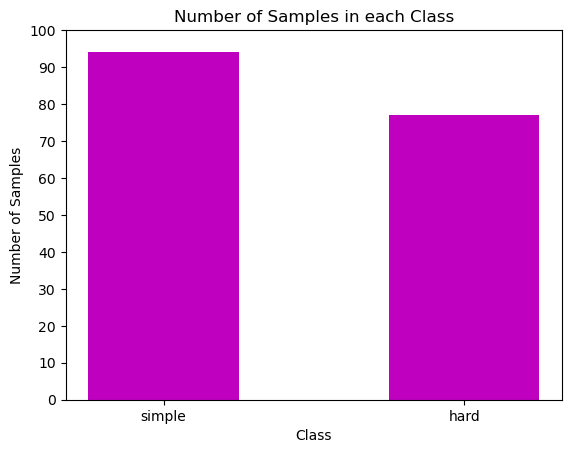

In [7]:
# plot the number of samples in each class to ensure the dataset is almost balanced by visualizing the class distribution
data = {'simple':94, 'hard':77}
x = list(data.keys())
y = list(data.values())

plt.bar(x, y, color='m', width=0.5)

plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.yticks(range(0, 110, 10))
plt.title('Number of Samples in each Class')
plt.show()

In [8]:
# make sure the data type of all the columns are suitable to be able to detect missing values
pcd_df.dtypes

Video Name          object
Video URL           object
Complexity Level    object
dtype: object

In [9]:
# check for missing values
pcd_df.isnull().sum()

Video Name          0
Video URL           0
Complexity Level    0
dtype: int64

In [10]:
# replace the categorical class labels (simple, hard) in 'Complexity Level' column to numerical values (0, 1)
pcd_df['Complexity Level'] = pcd_df['Complexity Level'].replace({'simple':0, 'hard':1})
pcd_df['Complexity Level'].value_counts()

0    94
1    77
Name: Complexity Level, dtype: int64

In [11]:
# video names in the presentation complexity dataset may include characters that will not be present in the names of those video files in the directory if it is not allowed according to the naming rules
# so, remove all non-English alphabet characters except the digits from the video names in the dataset to be able to compare with the video file names in the directory
for video_name in pcd_df['Video Name']:
    cleaned_video_name = re.sub(r'[^A-Za-z0-9]', '', video_name)
    pcd_df.loc[pcd_df['Video Name'] == video_name, 'Cleaned Video Name'] = cleaned_video_name
    
pcd_df.head()

,Video Name,Video URL,Complexity Level,Cleaned Video Name
0,Plant Parts and Functions for Kids,https://www.youtube.com/watch?v=18amLZ9vfG8,0,PlantPartsandFunctionsforKids
1,Adjectives for Kids | Homeschool Pop,https://www.youtube.com/watch?v=4jxXnHSbicY,0,AdjectivesforKidsHomeschoolPop
2,Roman Numerals For Kids,https://www.youtube.com/watch?v=NrnXsKYpLJM,0,RomanNumeralsForKids
3,Benjamin Franklin for Kids,https://www.youtube.com/watch?v=5LcMXnZfFFY,0,BenjaminFranklinforKids
4,Paul Revere for Kids,https://www.youtube.com/watch?v=dmwcfaythY4,0,PaulRevereforKids


## Video File Names Extraction

In [12]:
# get the path of the folder with simple video files
simple_path = os.path.join(folder, 'Downloaded Videos/Simple Videos')
simple_path

'C:/Users/kavis/Desktop/Junior-Senior Project (UOS)/AI Implementation/Presentation Complexity/Dataset Creation\\Downloaded Videos/Simple Videos'

In [13]:
# extract the names of the simple video files using the above path
# add the 'Simple Videos' directory name before every file name as this is different for simple and hard video paths
simple_video_files = os.listdir(simple_path)
simple_video_files = [('Simple Videos/' + video_filename) for video_filename in simple_video_files]
simple_video_files

['Simple Videos/01 - Review Of Fraction Concepts - (5th Grade Math).mp4',
 'Simple Videos/Addition of column vectors   - (Lesson 7 of 16 Mathematics Form 2 Topic Vectors I ).mp4',
 'Simple Videos/Adjectives (Part 1).mp4',
 'Simple Videos/Adjectives (Part 2).mp4',
 'Simple Videos/Adjectives for Kids  Homeschool Pop.mp4',
 'Simple Videos/Ancient Egypt 101  National Geographic.mp4',
 'Simple Videos/Ancient Egypt for Kids.mp4',
 'Simple Videos/Ancient Greece for Kids  History Learning Video.mp4',
 'Simple Videos/Ancient Mesopotamia 101  National Geographic.mp4',
 'Simple Videos/Articles (Part 1).mp4',
 'Simple Videos/Articles (Part 2).mp4',
 'Simple Videos/Articles (Part 3).mp4',
 'Simple Videos/Articles (Part 4).mp4',
 'Simple Videos/Articles (Solved Questions).mp4',
 'Simple Videos/Benjamin Franklin for Kids.mp4',
 'Simple Videos/Biotic & Abiotic Component Ecological Relationships  Grade 7 Science DepEd MELC Quarter 2 Module 6.mp4',
 'Simple Videos/Characteristics of Light  Grade 7 Scien

In [14]:
# get the path of the folder with hard video files
hard_path = os.path.join(folder, 'Downloaded Videos/Hard Videos')
hard_path

'C:/Users/kavis/Desktop/Junior-Senior Project (UOS)/AI Implementation/Presentation Complexity/Dataset Creation\\Downloaded Videos/Hard Videos'

In [15]:
# extract the names of the hard video files using the above path
# add the 'Hard Videos' directory name before every file name as this is different for simple and hard video paths
hard_video_files = os.listdir(hard_path)
hard_video_files = [('Hard Videos/' + video_filename) for video_filename in hard_video_files]
hard_video_files

['Hard Videos/5th Grade Math 110 Numerical Expressions from Words.mp4',
 'Hard Videos/5th Grade Math 27 Interpret the Remainder in Division.mp4',
 'Hard Videos/5th Grade Math 311 Word Problem Solving Add & Subtract Money.mp4',
 'Hard Videos/5th Grade Math 32 Place Value of Decimals ReadWrite Standard Expanded Word Forms.mp4',
 'Hard Videos/5th Grade Math 34 Round Decimals Using Place Value or Place-value Chart.mp4',
 'Hard Videos/5th Grade Math 35 Model Decimal Addition.mp4',
 'Hard Videos/5th Grade Math 36 Model Decimal Subtraction.mp4',
 'Hard Videos/5th Grade Math 46 Model Decimal by Decimal Multiplication.mp4',
 'Hard Videos/5th Grade Math 52 Model Dividing Decimals by Whole Numbers.mp4',
 'Hard Videos/5th Grade Math 53 Estimate Decimal Quotients.mp4',
 'Hard Videos/5th Grade Math 610 Use Properties of Addition to Add Fractions.mp4',
 'Hard Videos/5th Grade Math 62 Model Subtraction with Unlike Denominators.mp4',
 'Hard Videos/5th Grade Math 71 Find a Fractional Part of a Group.mp4

In [16]:
all_video_files = simple_video_files + hard_video_files
all_video_files

['Simple Videos/01 - Review Of Fraction Concepts - (5th Grade Math).mp4',
 'Simple Videos/Addition of column vectors   - (Lesson 7 of 16 Mathematics Form 2 Topic Vectors I ).mp4',
 'Simple Videos/Adjectives (Part 1).mp4',
 'Simple Videos/Adjectives (Part 2).mp4',
 'Simple Videos/Adjectives for Kids  Homeschool Pop.mp4',
 'Simple Videos/Ancient Egypt 101  National Geographic.mp4',
 'Simple Videos/Ancient Egypt for Kids.mp4',
 'Simple Videos/Ancient Greece for Kids  History Learning Video.mp4',
 'Simple Videos/Ancient Mesopotamia 101  National Geographic.mp4',
 'Simple Videos/Articles (Part 1).mp4',
 'Simple Videos/Articles (Part 2).mp4',
 'Simple Videos/Articles (Part 3).mp4',
 'Simple Videos/Articles (Part 4).mp4',
 'Simple Videos/Articles (Solved Questions).mp4',
 'Simple Videos/Benjamin Franklin for Kids.mp4',
 'Simple Videos/Biotic & Abiotic Component Ecological Relationships  Grade 7 Science DepEd MELC Quarter 2 Module 6.mp4',
 'Simple Videos/Characteristics of Light  Grade 7 Scien

In [17]:
# make sure all the simple and hard video file names have been extracted
len(all_video_files)

171

## Manual Feature Engineering and Analysis

In [18]:
# create a new dataframe to record the descriptive statistical values of all the features for analysis
feat_stats = pd.DataFrame(columns=['Complexity Level', 'Feature Name', 'Mean', 'Median', 'Max', 'Min'])
feat_stats

,Complexity Level,Feature Name,Mean,Median,Max,Min


### 1. Frame Rate (fps)

In [19]:
# get the video's frame rate in frames per second (fps)
def get_frame_rate(video_path):
    try:
        cap = cv.VideoCapture(video_path)
        frame_rate = cap.get(cv.CAP_PROP_FPS)
        
        return frame_rate
    finally:
        cap.release()

In [20]:
# get every video's frame rate (fps) and record it in the presentation complexity dataset
count = 0

video_folder = os.path.join(folder, 'Downloaded Videos')

for file in all_video_files:
    video_path = os.path.join(video_folder, file)
    f_rate = get_frame_rate(video_path)

    video_filename = os.path.basename(file)
    video_name = os.path.splitext(video_filename)[0]
    # remove all non-English alphabet characters except the digits from the names of the video files in the directory to be able to compare with the cleaned video names in the dataset
    cleaned_video_name = re.sub(r'[^A-Za-z0-9]', '', video_name)
    
    pcd_df.loc[pcd_df['Cleaned Video Name'] == cleaned_video_name, 'Frame Rate (fps)'] = f_rate
    
    count += 1
    if count % 10 == 0 or count == 171:
        print(f"{count} videos completed")

10 videos completed
20 videos completed
30 videos completed
40 videos completed
50 videos completed
60 videos completed
70 videos completed
80 videos completed
90 videos completed
100 videos completed
110 videos completed
120 videos completed
130 videos completed
140 videos completed
150 videos completed
160 videos completed
170 videos completed
171 videos completed


In [21]:
pcd_df.head()

,Video Name,Video URL,Complexity Level,Cleaned Video Name,Frame Rate (fps)
0,Plant Parts and Functions for Kids,https://www.youtube.com/watch?v=18amLZ9vfG8,0,PlantPartsandFunctionsforKids,25.0
1,Adjectives for Kids | Homeschool Pop,https://www.youtube.com/watch?v=4jxXnHSbicY,0,AdjectivesforKidsHomeschoolPop,25.0
2,Roman Numerals For Kids,https://www.youtube.com/watch?v=NrnXsKYpLJM,0,RomanNumeralsForKids,25.0
3,Benjamin Franklin for Kids,https://www.youtube.com/watch?v=5LcMXnZfFFY,0,BenjaminFranklinforKids,25.0
4,Paul Revere for Kids,https://www.youtube.com/watch?v=dmwcfaythY4,0,PaulRevereforKids,25.0


In [22]:
# store the mean, median, max, and min values of the videos' frame rate (fps) for each class (simple, hard) in the feat_stats dataframe
simple_f_rates = pcd_df.loc[pcd_df['Complexity Level'] == 0, 'Frame Rate (fps)']

s_mean = round(simple_f_rates.mean(), 5)
s_median = round(simple_f_rates.median(), 5)
s_max = round(simple_f_rates.max(), 5)
s_min = round(simple_f_rates.min(), 5)

hard_f_rates = pcd_df.loc[pcd_df['Complexity Level'] == 1, 'Frame Rate (fps)']

h_mean = round(hard_f_rates.mean(), 5)
h_median = round(hard_f_rates.median(), 5)
h_max = round(hard_f_rates.max(), 5)
h_min = round(hard_f_rates.min(), 5)

feat_stats = feat_stats.append([{'Complexity Level':'simple', 'Feature Name':'Frame Rate (fps)', 'Mean':s_mean, 'Median':s_median, 'Max':s_max, 'Min':s_min},
                               {'Complexity Level':'hard', 'Feature Name':'Frame Rate (fps)', 'Mean':h_mean, 'Median':h_median, 'Max':h_max, 'Min':h_min}], ignore_index=True)

feat_stats

,Complexity Level,Feature Name,Mean,Median,Max,Min
0,simple,Frame Rate (fps),26.32040,29.97003,30.0,10.0
1,hard,Frame Rate (fps),29.78602,30.00000,30.0,25.0


### 2. Scene Transition Rate (Per Minute)

In [23]:
# calculate the scene transition rate (per minute) using the formula: rate = total no. of scene transitions / video length (in minutes)
# adaptive detector algorithm is used to detect the scenes as it uses content detector algorithm for detection with minimal risk of detecting false scenes in situations like camera movements
# content detector algorithm detects scenes based on changes in colour and intensity between frames
def get_scene_trans_rate(video_path):
    try:
        scene_list = detect(video_path, AdaptiveDetector())
        
        if len(scene_list) == 0:
            total_scene_trans = 0
        else:
            total_scene_trans = len(scene_list) - 1

        cap = cv.VideoCapture(video_path)
        total_frames = cap.get(cv.CAP_PROP_FRAME_COUNT)
        frame_rate = cap.get(cv.CAP_PROP_FPS)
        video_length = (total_frames/frame_rate)/60

        scene_trans_rate = total_scene_trans/video_length

        return scene_trans_rate
    finally:
        cap.release()

In [24]:
# get every video's scene transition rate (per minute) and record it in the presentation complexity dataset
count = 0

video_folder = os.path.join(folder, 'Downloaded Videos')

for file in all_video_files:
    video_path = os.path.join(video_folder, file)
    st_rate = get_scene_trans_rate(video_path)
    
    video_filename = os.path.basename(file)
    video_name = os.path.splitext(video_filename)[0]
    # remove all non-English alphabet characters except the digits from the names of the video files in the directory to be able to compare with the cleaned video names in the dataset
    cleaned_video_name = re.sub(r'[^A-Za-z0-9]', '', video_name)
    
    pcd_df.loc[pcd_df['Cleaned Video Name'] == cleaned_video_name, 'Scene Transition Rate (Per Min)'] = st_rate
    
    count += 1
    if count % 10 == 0 or count == 171:
        print(f"{count} videos completed")

10 videos completed
20 videos completed
30 videos completed
40 videos completed
50 videos completed
60 videos completed
70 videos completed
80 videos completed
90 videos completed
100 videos completed
110 videos completed
120 videos completed
130 videos completed
140 videos completed
150 videos completed
160 videos completed
170 videos completed
171 videos completed


In [25]:
pcd_df.head()

,Video Name,Video URL,Complexity Level,Cleaned Video Name,Frame Rate (fps),Scene Transition Rate (Per Min)
0,Plant Parts and Functions for Kids,https://www.youtube.com/watch?v=18amLZ9vfG8,0,PlantPartsandFunctionsforKids,25.0,2.596279
1,Adjectives for Kids | Homeschool Pop,https://www.youtube.com/watch?v=4jxXnHSbicY,0,AdjectivesforKidsHomeschoolPop,25.0,1.874561
2,Roman Numerals For Kids,https://www.youtube.com/watch?v=NrnXsKYpLJM,0,RomanNumeralsForKids,25.0,1.475894
3,Benjamin Franklin for Kids,https://www.youtube.com/watch?v=5LcMXnZfFFY,0,BenjaminFranklinforKids,25.0,7.554297
4,Paul Revere for Kids,https://www.youtube.com/watch?v=dmwcfaythY4,0,PaulRevereforKids,25.0,6.286014


In [26]:
# store the mean, median, max, and min values of the videos' scene transition rate (per minute) for each class (simple, hard) in the feat_stats dataframe
simple_st_rates = pcd_df.loc[pcd_df['Complexity Level'] == 0, 'Scene Transition Rate (Per Min)']

s_mean = round(simple_st_rates.mean(), 5)
s_median = round(simple_st_rates.median(), 5)
s_max = round(simple_st_rates.max(), 5)
s_min = round(simple_st_rates.min(), 5)

hard_st_rates = pcd_df.loc[pcd_df['Complexity Level'] == 1, 'Scene Transition Rate (Per Min)']

h_mean = round(hard_st_rates.mean(), 5)
h_median = round(hard_st_rates.median(), 5)
h_max = round(hard_st_rates.max(), 5)
h_min = round(hard_st_rates.min(), 5)

feat_stats = feat_stats.append([{'Complexity Level':'simple', 'Feature Name':'Scene Transition Rate (Per Min)', 'Mean':s_mean, 'Median':s_median, 'Max':s_max, 'Min':s_min},
                               {'Complexity Level':'hard', 'Feature Name':'Scene Transition Rate (Per Min)', 'Mean':h_mean, 'Median':h_median, 'Max':h_max, 'Min':h_min}], ignore_index=True)

feat_stats

,Complexity Level,Feature Name,Mean,Median,Max,Min
0,simple,Frame Rate (fps),26.32040,29.97003,30.00000,10.0
1,hard,Frame Rate (fps),29.78602,30.00000,30.00000,25.0
2,simple,Scene Transition Rate (Per Min),1.36149,0.26367,10.09551,0.0
3,hard,Scene Transition Rate (Per Min),0.55590,0.39241,2.56345,0.0


### 3. Average Scene Duration (in Minutes)

In [27]:
# calculate the average scene duration in minutes using the formula: avg = total duration of all scenes (in minutes) / total no. of scenes
# if zero scenes are detected in a video, it means that there is only one scene spanning the whole video, so average scene duration = video length
# adaptive detector algorithm is used to detect the scenes as it uses content detector algorithm for detection with minimal risk of detecting false scenes in situations like camera movements
# content detector algorithm detects scenes based on changes in colour and intensity between frames
def get_avg_scene_dur(video_path):
    try: 
        total_duration = 0

        scene_list = detect(video_path, AdaptiveDetector())

        for scene in scene_list:
            start_time = (scene[0].get_frames()/scene[0].get_framerate())/60
            end_time = (scene[1].get_frames()/scene[1].get_framerate())/60
            duration = end_time - start_time
            total_duration += duration

        avg_scene_dur = total_duration / len(scene_list)

        return avg_scene_dur
    except ZeroDivisionError:
        try:
            cap = cv.VideoCapture(video_path)

            total_frames = cap.get(cv.CAP_PROP_FRAME_COUNT)
            frame_rate = cap.get(cv.CAP_PROP_FPS)

            video_length = (total_frames/frame_rate)/60
            avg_scene_dur = video_length

            return avg_scene_dur
        finally:
            cap.release()

In [28]:
# get every video's average scene duration in minutes and record it in the presentation complexity dataset
count = 0

video_folder = os.path.join(folder, 'Downloaded Videos')

for file in all_video_files:
    video_path = os.path.join(video_folder, file)
    avg_sd = get_avg_scene_dur(video_path)
    
    video_filename = os.path.basename(file)
    video_name = os.path.splitext(video_filename)[0]
    # remove all non-English alphabet characters except the digits from the names of the video files in the directory to be able to compare with the cleaned video names in the dataset
    cleaned_video_name = re.sub(r'[^A-Za-z0-9]', '', video_name)
    
    pcd_df.loc[pcd_df['Cleaned Video Name'] == cleaned_video_name, 'Average Scene Duration (in Mins)'] = avg_sd
    
    count += 1
    if count % 10 == 0 or count == 171:
        print(f"{count} videos completed")

10 videos completed
20 videos completed
30 videos completed
40 videos completed
50 videos completed
60 videos completed
70 videos completed
80 videos completed
90 videos completed
100 videos completed
110 videos completed
120 videos completed
130 videos completed
140 videos completed
150 videos completed
160 videos completed
170 videos completed
171 videos completed


In [29]:
pcd_df.head()

,Video Name,Video URL,Complexity Level,Cleaned Video Name,Frame Rate (fps),Scene Transition Rate (Per Min),Average Scene Duration (in Mins)
0,Plant Parts and Functions for Kids,https://www.youtube.com/watch?v=18amLZ9vfG8,0,PlantPartsandFunctionsforKids,25.0,2.596279,0.371885
1,Adjectives for Kids | Homeschool Pop,https://www.youtube.com/watch?v=4jxXnHSbicY,0,AdjectivesforKidsHomeschoolPop,25.0,1.874561,0.502078
2,Roman Numerals For Kids,https://www.youtube.com/watch?v=NrnXsKYpLJM,0,RomanNumeralsForKids,25.0,1.475894,0.609800
3,Benjamin Franklin for Kids,https://www.youtube.com/watch?v=5LcMXnZfFFY,0,BenjaminFranklinforKids,25.0,7.554297,0.124588
4,Paul Revere for Kids,https://www.youtube.com/watch?v=dmwcfaythY4,0,PaulRevereforKids,25.0,6.286014,0.149725


In [30]:
# store the mean, median, max, and min values of the videos' average scene duration (in minutes) for each class (simple, hard) in the feat_stats dataframe
simple_avg_sd = pcd_df.loc[pcd_df['Complexity Level'] == 0, 'Average Scene Duration (in Mins)']

s_mean = round(simple_avg_sd.mean(), 5)
s_median = round(simple_avg_sd.median(), 5)
s_max = round(simple_avg_sd.max(), 5)
s_min = round(simple_avg_sd.min(), 5)

hard_avg_sd = pcd_df.loc[pcd_df['Complexity Level'] == 1, 'Average Scene Duration (in Mins)']

h_mean = round(hard_avg_sd.mean(), 5)
h_median = round(hard_avg_sd.median(), 5)
h_max = round(hard_avg_sd.max(), 5)
h_min = round(hard_avg_sd.min(), 5)

feat_stats = feat_stats.append([{'Complexity Level':'simple', 'Feature Name':'Average Scene Duration (in Mins)', 'Mean':s_mean, 'Median':s_median, 'Max':s_max, 'Min':s_min},
                               {'Complexity Level':'hard', 'Feature Name':'Average Scene Duration (in Mins)', 'Mean':h_mean, 'Median':h_median, 'Max':h_max, 'Min':h_min}], ignore_index=True)

feat_stats

,Complexity Level,Feature Name,Mean,Median,Max,Min
0,simple,Frame Rate (fps),26.32040,29.97003,30.00000,10.00000
1,hard,Frame Rate (fps),29.78602,30.00000,30.00000,25.00000
2,simple,Scene Transition Rate (Per Min),1.36149,0.26367,10.09551,0.00000
3,hard,Scene Transition Rate (Per Min),0.55590,0.39241,2.56345,0.00000
4,simple,Average Scene Duration (in Mins),2.61202,2.00033,9.61627,0.09675
5,hard,Average Scene Duration (in Mins),2.41355,1.80778,8.44611,0.37237


### 4. Average Motion Intensity

In [31]:
# calculate the average motion intensity between one pair of consecutive frames using the formula: avg = total average magnitude of optical flow for all frame pairs / total number of frame pairs
# motion intensity is calculated using the optical flow method which detects the motion of objects between two consecutive frames in a video
# specifically, dense optical flow will be computed using the Gunnar Farneback algorithm as it looks at all the points in the image instead of corners like other algorithms
def get_avg_motion_intensity(frames): 
    total_frame_pairs = len(frames) - 1
    total_avg_mag = 0

    # assign the first frame as the previous frame
    prv_f = frames[0]

    for n in range(len(frames)-1):    
        next_f = frames[n+1]

        # convert the previous frame from BGR to grayscale
        prv_f_gray = cv.cvtColor(prv_f, cv.COLOR_BGR2GRAY)
        # convert the next frame (subsequent frame in the list) from BGR to grayscale
        next_f_gray = cv.cvtColor(next_f, cv.COLOR_BGR2GRAY)

        # calculate optical flow between the two consecutive frames
        flow = cv.calcOpticalFlowFarneback(prv_f_gray, next_f_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        # calculate the magnitude of the optical flow
        mag, _= cv.cartToPolar(flow[..., 0], flow[..., 1])

        total_avg_mag += np.mean(mag)

        # assign the next frame as the previous frame for the next optical flow computation
        prv_f = next_f

    avg_motion_intensity = total_avg_mag/total_frame_pairs

    return avg_motion_intensity

In [32]:
# get every video's average motion intensity and record it in the presentation complexity dataset
count = 0

video_folder = os.path.join(folder, 'Downloaded Videos')

for file in all_video_files:
    video_path = os.path.join(video_folder, file)
    frame_list = extract_frames(video_path)
    
    avg_mi = get_avg_motion_intensity(frame_list)
    
    video_filename = os.path.basename(file)
    video_name = os.path.splitext(video_filename)[0]
    # remove all non-English alphabet characters except the digits from the names of the video files in the directory to be able to compare with the cleaned video names in the dataset
    cleaned_video_name = re.sub(r'[^A-Za-z0-9]', '', video_name)
    
    pcd_df.loc[pcd_df['Cleaned Video Name'] == cleaned_video_name, 'Average Motion Intensity'] = avg_mi
    
    count += 1
    if count % 10 == 0 or count == 171:
        print(f"{count} videos completed")

10 videos completed
20 videos completed
30 videos completed
40 videos completed
50 videos completed
60 videos completed
70 videos completed
80 videos completed
90 videos completed
100 videos completed
110 videos completed
120 videos completed
130 videos completed
140 videos completed
150 videos completed
160 videos completed
170 videos completed
171 videos completed


In [33]:
pcd_df.head()

,Video Name,Video URL,Complexity Level,Cleaned Video Name,Frame Rate (fps),Scene Transition Rate (Per Min),Average Scene Duration (in Mins),Average Motion Intensity
0,Plant Parts and Functions for Kids,https://www.youtube.com/watch?v=18amLZ9vfG8,0,PlantPartsandFunctionsforKids,25.0,2.596279,0.371885,1.801748
1,Adjectives for Kids | Homeschool Pop,https://www.youtube.com/watch?v=4jxXnHSbicY,0,AdjectivesforKidsHomeschoolPop,25.0,1.874561,0.502078,0.569372
2,Roman Numerals For Kids,https://www.youtube.com/watch?v=NrnXsKYpLJM,0,RomanNumeralsForKids,25.0,1.475894,0.609800,1.104255
3,Benjamin Franklin for Kids,https://www.youtube.com/watch?v=5LcMXnZfFFY,0,BenjaminFranklinforKids,25.0,7.554297,0.124588,1.867790
4,Paul Revere for Kids,https://www.youtube.com/watch?v=dmwcfaythY4,0,PaulRevereforKids,25.0,6.286014,0.149725,2.819806


In [34]:
# store the mean, median, max, and min values of the videos' average motion intensity for each class (simple, hard) in the feat_stats dataframe
simple_avg_mi = pcd_df.loc[pcd_df['Complexity Level'] == 0, 'Average Motion Intensity']

s_mean = round(simple_avg_mi.mean(), 5)
s_median = round(simple_avg_mi.median(), 5)
s_max = round(simple_avg_mi.max(), 5)
s_min = round(simple_avg_mi.min(), 5)

hard_avg_mi = pcd_df.loc[pcd_df['Complexity Level'] == 1, 'Average Motion Intensity']

h_mean = round(hard_avg_mi.mean(), 5)
h_median = round(hard_avg_mi.median(), 5)
h_max = round(hard_avg_mi.max(), 5)
h_min = round(hard_avg_mi.min(), 5)

feat_stats = feat_stats.append([{'Complexity Level':'simple', 'Feature Name':'Average Motion Intensity', 'Mean':s_mean, 'Median':s_median, 'Max':s_max, 'Min':s_min},
                               {'Complexity Level':'hard', 'Feature Name':'Average Motion Intensity', 'Mean':h_mean, 'Median':h_median, 'Max':h_max, 'Min':h_min}], ignore_index=True)

feat_stats

,Complexity Level,Feature Name,Mean,Median,Max,Min
0,simple,Frame Rate (fps),26.32040,29.97003,30.00000,10.00000
1,hard,Frame Rate (fps),29.78602,30.00000,30.00000,25.00000
2,simple,Scene Transition Rate (Per Min),1.36149,0.26367,10.09551,0.00000
3,hard,Scene Transition Rate (Per Min),0.55590,0.39241,2.56345,0.00000
4,simple,Average Scene Duration (in Mins),2.61202,2.00033,9.61627,0.09675
5,hard,Average Scene Duration (in Mins),2.41355,1.80778,8.44611,0.37237
6,simple,Average Motion Intensity,1.70323,1.57052,8.56948,0.01448
7,hard,Average Motion Intensity,0.71676,0.64762,3.77642,0.22298


### 5. Texture Features - Average Texture Contrast, Average Texture Homogeneity

In [35]:
# calculate the average texture contrast and average texture homogeneity in one frame using the formula: avg = total average contrast or total average homogeneity / total number of frames
# compute the texture contrast and texture homegeneity features using Gray Level Co-occurrence Matrix (GLCM) method
# GLCM provides rich texture information by considering the pixel intensity relationships between neighbouring pixels
# texture contrast indicates the size of the variations between the neighbouring pixel intensities
# texture homogeneity indicates how uniform the texture is
def get_texture_features(frames):
    total_avg_contrast = 0
    total_avg_homogeneity = 0

    for frame in frames:
        # convert the frame from 3D BGR array to 2D grayscale array
        frame_gray = cv.cvtColor(np.array(frame), cv.COLOR_BGR2GRAY)
        # scale the grayscale frame pixel values from the normalized range [0, 1] to the 8-bit range [0, 255]
        # convert the scaled pixel values into uint8 data type to represent the values from 0 to 255
        image = (255 * frame_gray).astype(np.uint8)

        # create glcm from the image with 255 different gray intensity levels, using a distance of 50 between two pixels that are in the vertical direction as the parameters 
        glcm = graycomatrix(image, distances=[50], angles=[np.pi/2], levels=256)

        # extract the texture features using glcm
        contrast = graycoprops(glcm, 'contrast')
        homogeneity = graycoprops(glcm, 'homogeneity')

        total_avg_contrast += np.mean(contrast)
        total_avg_homogeneity += np.mean(homogeneity)

    avg_contrast = total_avg_contrast/len(frames)
    avg_homogeneity = total_avg_homogeneity/len(frames)

    return avg_contrast, avg_homogeneity

In [36]:
# get every video's texture features and record it in the presentation complexity dataset
count = 0

video_folder = os.path.join(folder, 'Downloaded Videos')

for file in all_video_files:
    video_path = os.path.join(video_folder, file)
    frame_list = extract_frames(video_path)
    
    avg_cont, avg_homo = get_texture_features(frame_list)
    
    video_filename = os.path.basename(file)
    video_name = os.path.splitext(video_filename)[0]
    # remove all non-English alphabet characters except the digits from the names of the video files in the directory to be able to compare with the cleaned video names in the dataset
    cleaned_video_name = re.sub(r'[^A-Za-z0-9]', '', video_name)
    
    pcd_df.loc[pcd_df['Cleaned Video Name'] == cleaned_video_name, 'Average Texture Contrast'] = avg_cont
    pcd_df.loc[pcd_df['Cleaned Video Name'] == cleaned_video_name, 'Average Texture Homogeneity'] = avg_homo
    
    count += 1
    if count % 10 == 0 or count == 171:
        print(f"{count} videos completed")

10 videos completed
20 videos completed
30 videos completed
40 videos completed
50 videos completed
60 videos completed
70 videos completed
80 videos completed
90 videos completed
100 videos completed
110 videos completed
120 videos completed
130 videos completed
140 videos completed
150 videos completed
160 videos completed
170 videos completed
171 videos completed


In [37]:
pcd_df.head()

,Video Name,Video URL,Complexity Level,Cleaned Video Name,Frame Rate (fps),Scene Transition Rate (Per Min),Average Scene Duration (in Mins),Average Motion Intensity,Average Texture Contrast,Average Texture Homogeneity
0,Plant Parts and Functions for Kids,https://www.youtube.com/watch?v=18amLZ9vfG8,0,PlantPartsandFunctionsforKids,25.0,2.596279,0.371885,1.801748,5111.683237,0.379146
1,Adjectives for Kids | Homeschool Pop,https://www.youtube.com/watch?v=4jxXnHSbicY,0,AdjectivesforKidsHomeschoolPop,25.0,1.874561,0.502078,0.569372,3943.115691,0.319201
2,Roman Numerals For Kids,https://www.youtube.com/watch?v=NrnXsKYpLJM,0,RomanNumeralsForKids,25.0,1.475894,0.609800,1.104255,3996.529243,0.362325
3,Benjamin Franklin for Kids,https://www.youtube.com/watch?v=5LcMXnZfFFY,0,BenjaminFranklinforKids,25.0,7.554297,0.124588,1.867790,4844.473094,0.412323
4,Paul Revere for Kids,https://www.youtube.com/watch?v=dmwcfaythY4,0,PaulRevereforKids,25.0,6.286014,0.149725,2.819806,6004.130270,0.404992


In [38]:
# store the mean, median, max, and min values of the videos' average texture contrast and average texture homogeneity for each class (simple, hard) in the feat_stats dataframe
simple_avg_cont = pcd_df.loc[pcd_df['Complexity Level'] == 0, 'Average Texture Contrast']

s_mean = round(simple_avg_cont.mean(), 5)
s_median = round(simple_avg_cont.median(), 5)
s_max = round(simple_avg_cont.max(), 5)
s_min = round(simple_avg_cont.min(), 5)

hard_avg_cont = pcd_df.loc[pcd_df['Complexity Level'] == 1, 'Average Texture Contrast']

h_mean = round(hard_avg_cont.mean(), 5)
h_median = round(hard_avg_cont.median(), 5)
h_max = round(hard_avg_cont.max(), 5)
h_min = round(hard_avg_cont.min(), 5)

feat_stats = feat_stats.append([{'Complexity Level':'simple', 'Feature Name':'Average Texture Contrast', 'Mean':s_mean, 'Median':s_median, 'Max':s_max, 'Min':s_min},
                               {'Complexity Level':'hard', 'Feature Name':'Average Texture Contrast', 'Mean':h_mean, 'Median':h_median, 'Max':h_max, 'Min':h_min}], ignore_index=True)


simple_avg_homo = pcd_df.loc[pcd_df['Complexity Level'] == 0, 'Average Texture Homogeneity']

s_mean = round(simple_avg_homo.mean(), 5)
s_median = round(simple_avg_homo.median(), 5)
s_max = round(simple_avg_homo.max(), 5)
s_min = round(simple_avg_homo.min(), 5)

hard_avg_homo = pcd_df.loc[pcd_df['Complexity Level'] == 1, 'Average Texture Homogeneity']

h_mean = round(hard_avg_homo.mean(), 5)
h_median = round(hard_avg_homo.median(), 5)
h_max = round(hard_avg_homo.max(), 5)
h_min = round(hard_avg_homo.min(), 5)

feat_stats = feat_stats.append([{'Complexity Level':'simple', 'Feature Name':'Average Texture Homogeneity', 'Mean':s_mean, 'Median':s_median, 'Max':s_max, 'Min':s_min},
                               {'Complexity Level':'hard', 'Feature Name':'Average Texture Homogeneity', 'Mean':h_mean, 'Median':h_median, 'Max':h_max, 'Min':h_min}], ignore_index=True)

feat_stats

,Complexity Level,Feature Name,Mean,Median,Max,Min
0,simple,Frame Rate (fps),26.32040,29.97003,30.00000,10.00000
1,hard,Frame Rate (fps),29.78602,30.00000,30.00000,25.00000
2,simple,Scene Transition Rate (Per Min),1.36149,0.26367,10.09551,0.00000
3,hard,Scene Transition Rate (Per Min),0.55590,0.39241,2.56345,0.00000
4,simple,Average Scene Duration (in Mins),2.61202,2.00033,9.61627,0.09675
5,hard,Average Scene Duration (in Mins),2.41355,1.80778,8.44611,0.37237
6,simple,Average Motion Intensity,1.70323,1.57052,8.56948,0.01448
7,hard,Average Motion Intensity,0.71676,0.64762,3.77642,0.22298
8,simple,Average Texture Contrast,3934.71321,2634.14408,17731.70404,1149.64255
9,hard,Average Texture Contrast,4420.29057,3673.05187,8367.47586,1727.62725


### 6. Dominant Color Standard Deviation

In [39]:
# calculate the dominant color standard deviation which is the square root of variance in dominant color in each color channgel (R, G, B) across the frames in a video
def get_dom_color_sd(frames):
    dom_colors = []
    
    for frame in frames:
        # convert numpy array of frame to image format and save it because ColorThief method only accepts image file
        image = im.fromarray(frame)
        image.save('temp_img.jpg')
        
        try:
            # get the one most dominant color from each frame
            dom_color = fast_colorthief.get_dominant_color('temp_img.jpg', quality=1)
        except RuntimeError:
            # if the color is greater than rgb(250, 250, 250), it will not be included in the array of colors by fast_colorthief
            # this may result in an empty array of colors that will give an error during quantization 
            # quantization is the process of picking the dominant color by reducing the number of colors in the array of colors obtained from the image
            # if this error occurs, dominant color will be set to the rgb(255, 255, 255) which is the maximum value
            dom_color = [255, 255, 255]
        
        # store the dominant color of every frame in a list
        dom_colors.append(dom_color)
        
        # remove the image file to save space for storing the next frame as image using the same name
        os.remove('temp_img.jpg')
        
    dom_color_sd = np.std(dom_colors, axis=0, dtype=np.float64)
    
    return dom_color_sd

In [40]:
# get every video's dominant color standard deviation and record it in the presentation complexity dataset
count = 0

video_folder = os.path.join(folder, 'Downloaded Videos')

for file in all_video_files:
    video_path = os.path.join(video_folder, file)
    frame_list = extract_frames(video_path)
    
    dc_sd = get_dom_color_sd(frame_list)
    
    video_filename = os.path.basename(file)
    video_name = os.path.splitext(video_filename)[0]
    # remove all non-English alphabet characters except the digits from the names of the video files in the directory to be able to compare with the cleaned video names in the dataset
    cleaned_video_name = re.sub(r'[^A-Za-z0-9]', '', video_name)
    
    pcd_df.loc[pcd_df['Cleaned Video Name'] == cleaned_video_name, 'Dominant Color Standard Deviation (R)'] = dc_sd[0]
    pcd_df.loc[pcd_df['Cleaned Video Name'] == cleaned_video_name, 'Dominant Color Standard Deviation (G)'] = dc_sd[1]
    pcd_df.loc[pcd_df['Cleaned Video Name'] == cleaned_video_name, 'Dominant Color Standard Deviation (B)'] = dc_sd[2]
    
    count += 1
    if count % 10 == 0 or count == 171:
        print(f"{count} videos completed")

10 videos completed
20 videos completed
30 videos completed
40 videos completed
50 videos completed
60 videos completed
70 videos completed
80 videos completed
90 videos completed
100 videos completed
110 videos completed
120 videos completed
130 videos completed
140 videos completed
150 videos completed
160 videos completed
170 videos completed
171 videos completed


In [41]:
pcd_df.head()

,Video Name,Video URL,Complexity Level,Cleaned Video Name,Frame Rate (fps),Scene Transition Rate (Per Min),Average Scene Duration (in Mins),Average Motion Intensity,Average Texture Contrast,Average Texture Homogeneity,Dominant Color Standard Deviation (R),Dominant Color Standard Deviation (G),Dominant Color Standard Deviation (B)
0,Plant Parts and Functions for Kids,https://www.youtube.com/watch?v=18amLZ9vfG8,0,PlantPartsandFunctionsforKids,25.0,2.596279,0.371885,1.801748,5111.683237,0.379146,82.994624,68.282270,67.973004
1,Adjectives for Kids | Homeschool Pop,https://www.youtube.com/watch?v=4jxXnHSbicY,0,AdjectivesforKidsHomeschoolPop,25.0,1.874561,0.502078,0.569372,3943.115691,0.319201,72.648775,70.043557,83.526724
2,Roman Numerals For Kids,https://www.youtube.com/watch?v=NrnXsKYpLJM,0,RomanNumeralsForKids,25.0,1.475894,0.609800,1.104255,3996.529243,0.362325,80.947498,78.241961,75.806626
3,Benjamin Franklin for Kids,https://www.youtube.com/watch?v=5LcMXnZfFFY,0,BenjaminFranklinforKids,25.0,7.554297,0.124588,1.867790,4844.473094,0.412323,72.428249,78.067785,77.097537
4,Paul Revere for Kids,https://www.youtube.com/watch?v=dmwcfaythY4,0,PaulRevereforKids,25.0,6.286014,0.149725,2.819806,6004.130270,0.404992,67.448256,74.333054,67.625711


In [42]:
# store the mean, median, max, and min values of the videos' dominant color standard deviation in R, G, B color channels for each class (simple, hard) in the feat_stats dataframe
simple_dc_sd = pcd_df.loc[pcd_df['Complexity Level'] == 0, 'Dominant Color Standard Deviation (R)']

s_mean = round(simple_dc_sd.mean(), 5)
s_median = round(simple_dc_sd.median(), 5)
s_max = round(simple_dc_sd.max(), 5)
s_min = round(simple_dc_sd.min(), 5)

hard_dc_sd = pcd_df.loc[pcd_df['Complexity Level'] == 1, 'Dominant Color Standard Deviation (R)']

h_mean = round(hard_dc_sd.mean(), 5)
h_median = round(hard_dc_sd.median(), 5)
h_max = round(hard_dc_sd.max(), 5)
h_min = round(hard_dc_sd.min(), 5)

feat_stats = feat_stats.append([{'Complexity Level':'simple', 'Feature Name':'Dominant Color Standard Deviation (R)', 'Mean':s_mean, 'Median':s_median, 'Max':s_max, 'Min':s_min},
                               {'Complexity Level':'hard', 'Feature Name':'Dominant Color Standard Deviation (R)', 'Mean':h_mean, 'Median':h_median, 'Max':h_max, 'Min':h_min}], ignore_index=True)

simple_dc_sd = pcd_df.loc[pcd_df['Complexity Level'] == 0, 'Dominant Color Standard Deviation (G)']

s_mean = round(simple_dc_sd.mean(), 5)
s_median = round(simple_dc_sd.median(), 5)
s_max = round(simple_dc_sd.max(), 5)
s_min = round(simple_dc_sd.min(), 5)

hard_dc_sd = pcd_df.loc[pcd_df['Complexity Level'] == 1, 'Dominant Color Standard Deviation (G)']

h_mean = round(hard_dc_sd.mean(), 5)
h_median = round(hard_dc_sd.median(), 5)
h_max = round(hard_dc_sd.max(), 5)
h_min = round(hard_dc_sd.min(), 5)

feat_stats = feat_stats.append([{'Complexity Level':'simple', 'Feature Name':'Dominant Color Standard Deviation (G)', 'Mean':s_mean, 'Median':s_median, 'Max':s_max, 'Min':s_min},
                               {'Complexity Level':'hard', 'Feature Name':'Dominant Color Standard Deviation (G)', 'Mean':h_mean, 'Median':h_median, 'Max':h_max, 'Min':h_min}], ignore_index=True)

simple_dc_sd = pcd_df.loc[pcd_df['Complexity Level'] == 0, 'Dominant Color Standard Deviation (B)']

s_mean = round(simple_dc_sd.mean(), 5)
s_median = round(simple_dc_sd.median(), 5)
s_max = round(simple_dc_sd.max(), 5)
s_min = round(simple_dc_sd.min(), 5)

hard_dc_sd = pcd_df.loc[pcd_df['Complexity Level'] == 1, 'Dominant Color Standard Deviation (B)']

h_mean = round(hard_dc_sd.mean(), 5)
h_median = round(hard_dc_sd.median(), 5)
h_max = round(hard_dc_sd.max(), 5)
h_min = round(hard_dc_sd.min(), 5)

feat_stats = feat_stats.append([{'Complexity Level':'simple', 'Feature Name':'Dominant Color Standard Deviation (B)', 'Mean':s_mean, 'Median':s_median, 'Max':s_max, 'Min':s_min},
                               {'Complexity Level':'hard', 'Feature Name':'Dominant Color Standard Deviation (B)', 'Mean':h_mean, 'Median':h_median, 'Max':h_max, 'Min':h_min}], ignore_index=True)

feat_stats

,Complexity Level,Feature Name,Mean,Median,Max,Min
0,simple,Frame Rate (fps),26.32040,29.97003,30.00000,10.00000
1,hard,Frame Rate (fps),29.78602,30.00000,30.00000,25.00000
2,simple,Scene Transition Rate (Per Min),1.36149,0.26367,10.09551,0.00000
3,hard,Scene Transition Rate (Per Min),0.55590,0.39241,2.56345,0.00000
4,simple,Average Scene Duration (in Mins),2.61202,2.00033,9.61627,0.09675
5,hard,Average Scene Duration (in Mins),2.41355,1.80778,8.44611,0.37237
6,simple,Average Motion Intensity,1.70323,1.57052,8.56948,0.01448
7,hard,Average Motion Intensity,0.71676,0.64762,3.77642,0.22298
8,simple,Average Texture Contrast,3934.71321,2634.14408,17731.70404,1149.64255
9,hard,Average Texture Contrast,4420.29057,3673.05187,8367.47586,1727.62725


### 7. Bit Rate (Mbps)

In [47]:
# get the video's bit rate in mega bits per second (Mbps) using the formula bit rate = ((video file size * 8)/video_length)/(10^6)
# bit rate is the number of bits or amount of data conveyed per unit time
def get_bit_rate(video_path):
    try:
        video_file_size = os.path.getsize(video_path)

        cap = cv.VideoCapture(video_path)
        total_frames = cap.get(cv.CAP_PROP_FRAME_COUNT)
        frame_rate = cap.get(cv.CAP_PROP_FPS)
        video_length = total_frames/frame_rate

        bit_rate = ((video_file_size * 8)/video_length)/(10**6)

        return bit_rate
    finally:
        cap.release()

In [48]:
# get every video's bit rate (Mbps) and record it in the presentation complexity dataset
count = 0

video_folder = os.path.join(folder, 'Downloaded Videos')

for file in all_video_files:
    video_path = os.path.join(video_folder, file)
    b_rate = get_bit_rate(video_path)
    
    video_filename = os.path.basename(file)
    video_name = os.path.splitext(video_filename)[0]
    # remove all non-English alphabet characters except the digits from the names of the video files in the directory to be able to compare with the cleaned video names in the dataset
    cleaned_video_name = re.sub(r'[^A-Za-z0-9]', '', video_name)
    
    pcd_df.loc[pcd_df['Cleaned Video Name'] == cleaned_video_name, 'Bit Rate (Mbps)'] = b_rate
    
    count += 1
    if count % 10 == 0 or count == 171:
        print(f"{count} videos completed")

10 videos completed
20 videos completed
30 videos completed
40 videos completed
50 videos completed
60 videos completed
70 videos completed
80 videos completed
90 videos completed
100 videos completed
110 videos completed
120 videos completed
130 videos completed
140 videos completed
150 videos completed
160 videos completed
170 videos completed
171 videos completed


In [49]:
pcd_df.head()

,Video Name,Video URL,Complexity Level,Cleaned Video Name,Frame Rate (fps),Scene Transition Rate (Per Min),Average Scene Duration (in Mins),Average Motion Intensity,Average Texture Contrast,Average Texture Homogeneity,Dominant Color Standard Deviation (R),Dominant Color Standard Deviation (G),Dominant Color Standard Deviation (B),Average Color Histogram (R),Average Color Histogram (G),Average Color Histogram (B),Bit Rate (Mbps)
0,Plant Parts and Functions for Kids,https://www.youtube.com/watch?v=18amLZ9vfG8,0,PlantPartsandFunctionsforKids,25.0,2.596279,0.371885,1.801748,5111.683237,0.379146,82.994624,68.282270,67.973004,900.0,900.0,900.0,0.181855
1,Adjectives for Kids | Homeschool Pop,https://www.youtube.com/watch?v=4jxXnHSbicY,0,AdjectivesforKidsHomeschoolPop,25.0,1.874561,0.502078,0.569372,3943.115691,0.319201,72.648775,70.043557,83.526724,900.0,900.0,900.0,0.161331
2,Roman Numerals For Kids,https://www.youtube.com/watch?v=NrnXsKYpLJM,0,RomanNumeralsForKids,25.0,1.475894,0.609800,1.104255,3996.529243,0.362325,80.947498,78.241961,75.806626,900.0,900.0,900.0,0.176696
3,Benjamin Franklin for Kids,https://www.youtube.com/watch?v=5LcMXnZfFFY,0,BenjaminFranklinforKids,25.0,7.554297,0.124588,1.867790,4844.473094,0.412323,72.428249,78.067785,77.097537,900.0,900.0,900.0,0.232962
4,Paul Revere for Kids,https://www.youtube.com/watch?v=dmwcfaythY4,0,PaulRevereforKids,25.0,6.286014,0.149725,2.819806,6004.130270,0.404992,67.448256,74.333054,67.625711,900.0,900.0,900.0,0.218057


In [50]:
# store the mean, median, max, and min values of the videos' bit rate (Mbps) for each class (simple, hard) in the feat_stats dataframe
simple_b_rate = pcd_df.loc[pcd_df['Complexity Level'] == 0, 'Bit Rate (Mbps)']

s_mean = round(simple_b_rate.mean(), 5)
s_median = round(simple_b_rate.median(), 5)
s_max = round(simple_b_rate.max(), 5)
s_min = round(simple_b_rate.min(), 5)

hard_b_rate = pcd_df.loc[pcd_df['Complexity Level'] == 1, 'Bit Rate (Mbps)']

h_mean = round(hard_b_rate.mean(), 5)
h_median = round(hard_b_rate.median(), 5)
h_max = round(hard_b_rate.max(), 5)
h_min = round(hard_b_rate.min(), 5)

feat_stats = feat_stats.append([{'Complexity Level':'simple', 'Feature Name':'Bit Rate (Mbps)', 'Mean':s_mean, 'Median':s_median, 'Max':s_max, 'Min':s_min},
                               {'Complexity Level':'hard', 'Feature Name':'Bit Rate (Mbps)', 'Mean':h_mean, 'Median':h_median, 'Max':h_max, 'Min':h_min}], ignore_index=True)

feat_stats

,Complexity Level,Feature Name,Mean,Median,Max,Min
0,simple,Frame Rate (fps),26.32040,29.97003,30.00000,10.00000
1,hard,Frame Rate (fps),29.78602,30.00000,30.00000,25.00000
2,simple,Scene Transition Rate (Per Min),1.36149,0.26367,10.09551,0.00000
3,hard,Scene Transition Rate (Per Min),0.55590,0.39241,2.56345,0.00000
4,simple,Average Scene Duration (in Mins),2.61202,2.00033,9.61627,0.09675
5,hard,Average Scene Duration (in Mins),2.41355,1.80778,8.44611,0.37237
6,simple,Average Motion Intensity,1.70323,1.57052,8.56948,0.01448
7,hard,Average Motion Intensity,0.71676,0.64762,3.77642,0.22298
8,simple,Average Texture Contrast,3934.71321,2634.14408,17731.70404,1149.64255
9,hard,Average Texture Contrast,4420.29057,3673.05187,8367.47586,1727.62725


### 8. Compression Ratio

In [61]:
# calculate the compression ratio using the formula: ratio = video file size (compressed when downloaded)/video stream size (original from YouTube)
def get_comp_ratio(video_path, video_url):
    video_file_size = os.path.getsize(video_path)
    
    video_object = yt(video_url)
    video_stream = video_object.streams.filter(file_extension='mp4').get_highest_resolution()
    video_stream_size = video_stream.filesize
    
    comp_ratio = video_file_size/video_stream_size
    
    return comp_ratio

In [65]:
# get every video's compression ratio and record it in the presentation complexity dataset
count = 0

video_folder = os.path.join(folder, 'Downloaded Videos')

for file in all_video_files:
    video_path = os.path.join(video_folder, file)
    
    video_filename = os.path.basename(file)
    video_name = os.path.splitext(video_filename)[0]
    # remove all non-English alphabet characters except the digits from the names of the video files in the directory to be able to compare with the cleaned video names in the dataset
    cleaned_video_name = re.sub(r'[^A-Za-z0-9]', '', video_name)
    
    video_url = pcd_df.loc[pcd_df['Cleaned Video Name'] == cleaned_video_name, 'Video URL']
    
    c_ratio = get_comp_ratio(video_path, str(video_url))
    
    pcd_df.loc[pcd_df['Cleaned Video Name'] == cleaned_video_name, 'Compression Ratio'] = c_ratio
    
    count += 1
    if count % 10 == 0 or count == 171:
        print(f"{count} videos completed")

10 videos completed
20 videos completed
30 videos completed
40 videos completed
50 videos completed
60 videos completed
70 videos completed
80 videos completed
90 videos completed
100 videos completed
110 videos completed
120 videos completed
130 videos completed
140 videos completed
150 videos completed
160 videos completed
170 videos completed
171 videos completed


In [73]:
pcd_df.head()

,Video Name,Video URL,Complexity Level,Cleaned Video Name,Frame Rate (fps),Scene Transition Rate (Per Min),Average Scene Duration (in Mins),Average Motion Intensity,Average Texture Contrast,Average Texture Homogeneity,Dominant Color Standard Deviation (R),Dominant Color Standard Deviation (G),Dominant Color Standard Deviation (B),Average Color Histogram (R),Average Color Histogram (G),Average Color Histogram (B),Bit Rate (Mbps),Compression Ratio
0,Plant Parts and Functions for Kids,https://www.youtube.com/watch?v=18amLZ9vfG8,0,PlantPartsandFunctionsforKids,25.0,2.596279,0.371885,1.801748,5111.683237,0.379146,82.994624,68.282270,67.973004,900.0,900.0,900.0,0.181855,0.396224
1,Adjectives for Kids | Homeschool Pop,https://www.youtube.com/watch?v=4jxXnHSbicY,0,AdjectivesforKidsHomeschoolPop,25.0,1.874561,0.502078,0.569372,3943.115691,0.319201,72.648775,70.043557,83.526724,900.0,900.0,900.0,0.161331,0.278195
2,Roman Numerals For Kids,https://www.youtube.com/watch?v=NrnXsKYpLJM,0,RomanNumeralsForKids,25.0,1.475894,0.609800,1.104255,3996.529243,0.362325,80.947498,78.241961,75.806626,900.0,900.0,900.0,0.176696,0.217683
3,Benjamin Franklin for Kids,https://www.youtube.com/watch?v=5LcMXnZfFFY,0,BenjaminFranklinforKids,25.0,7.554297,0.124588,1.867790,4844.473094,0.412323,72.428249,78.067785,77.097537,900.0,900.0,900.0,0.232962,0.099683
4,Paul Revere for Kids,https://www.youtube.com/watch?v=dmwcfaythY4,0,PaulRevereforKids,25.0,6.286014,0.149725,2.819806,6004.130270,0.404992,67.448256,74.333054,67.625711,900.0,900.0,900.0,0.218057,0.112131


In [76]:
# store the mean, median, max, and min values of the videos' compression ratio for each class (simple, hard) in the feat_stats dataframe
simple_c_ratio = pcd_df.loc[pcd_df['Complexity Level'] == 0, 'Compression Ratio']

s_mean = round(simple_c_ratio.mean(), 5)
s_median = round(simple_c_ratio.median(), 5)
s_max = round(simple_c_ratio.max(), 5)
s_min = round(simple_c_ratio.min(), 5)

hard_c_ratio = pcd_df.loc[pcd_df['Complexity Level'] == 1, 'Compression Ratio']

h_mean = round(hard_c_ratio.mean(), 5)
h_median = round(hard_c_ratio.median(), 5)
h_max = round(hard_c_ratio.max(), 5)
h_min = round(hard_c_ratio.min(), 5)

feat_stats = feat_stats.append([{'Complexity Level':'simple', 'Feature Name':'Compression Ratio', 'Mean':s_mean, 'Median':s_median, 'Max':s_max, 'Min':s_min},
                               {'Complexity Level':'hard', 'Feature Name':'Compression Ratio', 'Mean':h_mean, 'Median':h_median, 'Max':h_max, 'Min':h_min}], ignore_index=True)

feat_stats

,Complexity Level,Feature Name,Mean,Median,Max,Min
0,simple,Frame Rate (fps),26.32040,29.97003,30.00000,10.00000
1,hard,Frame Rate (fps),29.78602,30.00000,30.00000,25.00000
2,simple,Scene Transition Rate (Per Min),1.36149,0.26367,10.09551,0.00000
3,hard,Scene Transition Rate (Per Min),0.55590,0.39241,2.56345,0.00000
4,simple,Average Scene Duration (in Mins),2.61202,2.00033,9.61627,0.09675
5,hard,Average Scene Duration (in Mins),2.41355,1.80778,8.44611,0.37237
6,simple,Average Motion Intensity,1.70323,1.57052,8.56948,0.01448
7,hard,Average Motion Intensity,0.71676,0.64762,3.77642,0.22298
8,simple,Average Texture Contrast,3934.71321,2634.14408,17731.70404,1149.64255
9,hard,Average Texture Contrast,4420.29057,3673.05187,8367.47586,1727.62725


### 9. Average Peak Signal-to-Noise Ratio (PSNR) (dB)

In [75]:
# calculate the PSNR in decibels (dB) between two consecutive images or frames
# PSNR indicates the quality of an image by computing the ratio between the maximum power of a signal and the power of noise in an image
def img_psnr(img1, img2):
    # compute mse
    mse = np.mean((img1 / 255.0 - img2 / 255.0) ** 2)
    
    # compute psnr
    if mse < 1e-10:
        psnr = 100
    else:
        psnr = 20 * math.log10(1 / math.sqrt(mse))
        
    return psnr

In [76]:
# calculate the PSNR for all the frames in a video and find the average PSNR in decibals (dB)
def calculate_avg_psnr(frames):
    psnr_results = []
    
    for i in range(1, len(frames)):
        psnr = img_psnr(frames[i - 1], frames[i])
        psnr_results.append(psnr)

    mean_psnr = np.mean(psnr_results) if psnr_results else 0
    
    return mean_psnr

In [77]:
# get every video's average PSNR (dB) and record it in the presentation complexity dataset
count = 0

video_folder = os.path.join(folder, 'Downloaded Videos')

for file in all_video_files:
    video_path = os.path.join(video_folder, file)
    frame_list = extract_frames(video_path)
        
    avg_psnr = calculate_avg_psnr(frame_list)
    
    video_filename = os.path.basename(file)
    video_name = os.path.splitext(video_filename)[0]
    # remove all non-English alphabet characters except the digits from the names of the video files in the directory to be able to compare with the cleaned video names in the dataset
    cleaned_video_name = re.sub(r'[^A-Za-z0-9]', '', video_name)
            
    pcd_df.loc[pcd_df['Cleaned Video Name'] == cleaned_video_name, 'Average PSNR (dB)'] = avg_psnr
    
    count += 1
    if count % 10 == 0 or count == 171:
        print(f"{count} videos completed")

10 videos completed
20 videos completed
30 videos completed
40 videos completed
50 videos completed
60 videos completed
70 videos completed
80 videos completed
90 videos completed
100 videos completed
110 videos completed
120 videos completed
130 videos completed
140 videos completed
150 videos completed
160 videos completed
170 videos completed
171 videos completed


In [78]:
pcd_df.head()

,Video Name,Video URL,Complexity Level,Cleaned Video Name,Frame Rate (fps),Scene Transition Rate (Per Min),Average Scene Duration (in Mins),Average Motion Intensity,Average Texture Contrast,Average Texture Homogeneity,Dominant Color Standard Deviation (R),Dominant Color Standard Deviation (G),Dominant Color Standard Deviation (B),Average Color Histogram (R),Average Color Histogram (G),Average Color Histogram (B),Bit Rate (Mbps),Compression Ratio,Average PSNR (dB)
0,Plant Parts and Functions for Kids,https://www.youtube.com/watch?v=18amLZ9vfG8,0,PlantPartsandFunctionsforKids,25.0,2.596279,0.371885,1.801748,5111.683237,0.379146,82.994624,68.282270,67.973004,900.0,900.0,900.0,0.181855,0.396224,46.203267
1,Adjectives for Kids | Homeschool Pop,https://www.youtube.com/watch?v=4jxXnHSbicY,0,AdjectivesforKidsHomeschoolPop,25.0,1.874561,0.502078,0.569372,3943.115691,0.319201,72.648775,70.043557,83.526724,900.0,900.0,900.0,0.161331,0.278195,55.694422
2,Roman Numerals For Kids,https://www.youtube.com/watch?v=NrnXsKYpLJM,0,RomanNumeralsForKids,25.0,1.475894,0.609800,1.104255,3996.529243,0.362325,80.947498,78.241961,75.806626,900.0,900.0,900.0,0.176696,0.217683,49.813713
3,Benjamin Franklin for Kids,https://www.youtube.com/watch?v=5LcMXnZfFFY,0,BenjaminFranklinforKids,25.0,7.554297,0.124588,1.867790,4844.473094,0.412323,72.428249,78.067785,77.097537,900.0,900.0,900.0,0.232962,0.099683,37.454033
4,Paul Revere for Kids,https://www.youtube.com/watch?v=dmwcfaythY4,0,PaulRevereforKids,25.0,6.286014,0.149725,2.819806,6004.130270,0.404992,67.448256,74.333054,67.625711,900.0,900.0,900.0,0.218057,0.112131,53.370351


In [81]:
# store the mean, median, max, and min values of the videos' average PSNR (dB) for each class (simple, hard) in the feat_stats dataframe
simple_avg_psnr = pcd_df.loc[pcd_df['Complexity Level'] == 0, 'Average PSNR (dB)']

s_mean = round(simple_avg_psnr.mean(), 5)
s_median = round(simple_avg_psnr.median(), 5)
s_max = round(simple_avg_psnr.max(), 5)
s_min = round(simple_avg_psnr.min(), 5)

hard_avg_psnr = pcd_df.loc[pcd_df['Complexity Level'] == 1, 'Average PSNR (dB)']

h_mean = round(hard_avg_psnr.mean(), 5)
h_median = round(hard_avg_psnr.median(), 5)
h_max = round(hard_avg_psnr.max(), 5)
h_min = round(hard_avg_psnr.min(), 5)

feat_stats = feat_stats.append([{'Complexity Level':'simple', 'Feature Name':'Average PSNR (dB)', 'Mean':s_mean, 'Median':s_median, 'Max':s_max, 'Min':s_min},
                               {'Complexity Level':'hard', 'Feature Name':'Average PSNR (dB)', 'Mean':h_mean, 'Median':h_median, 'Max':h_max, 'Min':h_min}], ignore_index=True)

feat_stats

,Complexity Level,Feature Name,Mean,Median,Max,Min
0,simple,Frame Rate (fps),26.32040,29.97003,30.00000,10.00000
1,hard,Frame Rate (fps),29.78602,30.00000,30.00000,25.00000
2,simple,Scene Transition Rate (Per Min),1.36149,0.26367,10.09551,0.00000
3,hard,Scene Transition Rate (Per Min),0.55590,0.39241,2.56345,0.00000
4,simple,Average Scene Duration (in Mins),2.61202,2.00033,9.61627,0.09675
5,hard,Average Scene Duration (in Mins),2.41355,1.80778,8.44611,0.37237
6,simple,Average Motion Intensity,1.70323,1.57052,8.56948,0.01448
7,hard,Average Motion Intensity,0.71676,0.64762,3.77642,0.22298
8,simple,Average Texture Contrast,3934.71321,2634.14408,17731.70404,1149.64255
9,hard,Average Texture Contrast,4420.29057,3673.05187,8367.47586,1727.62725


### 10. Average Structural Similarity Index (SSIM)

In [80]:
# calculate the SSIM between two consecutive images or frames
# SSIM measures the similarity between two images based on the difference in luminance, contrast, and structure
def img_ssim(img1, img2):
    # convert images to grayscale for SSIM calculation
    img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
    img2_gray = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
    
    ssim_index, _ = compare_ssim(img1_gray, img2_gray, full=True)
    
    return ssim_index

In [81]:
# calculate the SSIM for all the frames in a video and find the average SSIM
def calculate_avg_ssim(frames):
    ssim_results = []

    for i in range(1, len(frames)):
        ssim = img_ssim(frames[i - 1], frames[i])
        ssim_results.append(ssim)

    mean_ssim = np.mean(ssim_results) if ssim_results else 0
    
    return mean_ssim

In [82]:
# get every video's average SSIM and record it in the presentation complexity dataset
count = 0

video_folder = os.path.join(folder, 'Downloaded Videos')

for file in all_video_files:
    video_path = os.path.join(video_folder, file)
    frame_list = extract_frames(video_path)
        
    avg_ssim = calculate_avg_ssim(frame_list)
    
    video_filename = os.path.basename(file)
    video_name = os.path.splitext(video_filename)[0]
    # remove all non-English alphabet characters except the digits from the names of the video files in the directory to be able to compare with the cleaned video names in the dataset
    cleaned_video_name = re.sub(r'[^A-Za-z0-9]', '', video_name)
            
    pcd_df.loc[pcd_df['Cleaned Video Name'] == cleaned_video_name, 'Average SSIM'] = avg_ssim
    
    count += 1
    if count % 10 == 0 or count == 171:
        print(f"{count} videos completed")

10 videos completed
20 videos completed
30 videos completed
40 videos completed
50 videos completed
60 videos completed
70 videos completed
80 videos completed
90 videos completed
100 videos completed
110 videos completed
120 videos completed
130 videos completed
140 videos completed
150 videos completed
160 videos completed
170 videos completed
171 videos completed


In [83]:
pcd_df.head()

,Video Name,Video URL,Complexity Level,Cleaned Video Name,Frame Rate (fps),Scene Transition Rate (Per Min),Average Scene Duration (in Mins),Average Motion Intensity,Average Texture Contrast,Average Texture Homogeneity,Dominant Color Standard Deviation (R),Dominant Color Standard Deviation (G),Dominant Color Standard Deviation (B),Average Color Histogram (R),Average Color Histogram (G),Average Color Histogram (B),Bit Rate (Mbps),Compression Ratio,Average PSNR (dB),Average SSIM
0,Plant Parts and Functions for Kids,https://www.youtube.com/watch?v=18amLZ9vfG8,0,PlantPartsandFunctionsforKids,25.0,2.596279,0.371885,1.801748,5111.683237,0.379146,82.994624,68.282270,67.973004,900.0,900.0,900.0,0.181855,0.396224,46.203267,0.930128
1,Adjectives for Kids | Homeschool Pop,https://www.youtube.com/watch?v=4jxXnHSbicY,0,AdjectivesforKidsHomeschoolPop,25.0,1.874561,0.502078,0.569372,3943.115691,0.319201,72.648775,70.043557,83.526724,900.0,900.0,900.0,0.161331,0.278195,55.694422,0.971648
2,Roman Numerals For Kids,https://www.youtube.com/watch?v=NrnXsKYpLJM,0,RomanNumeralsForKids,25.0,1.475894,0.609800,1.104255,3996.529243,0.362325,80.947498,78.241961,75.806626,900.0,900.0,900.0,0.176696,0.217683,49.813713,0.938447
3,Benjamin Franklin for Kids,https://www.youtube.com/watch?v=5LcMXnZfFFY,0,BenjaminFranklinforKids,25.0,7.554297,0.124588,1.867790,4844.473094,0.412323,72.428249,78.067785,77.097537,900.0,900.0,900.0,0.232962,0.099683,37.454033,0.908600
4,Paul Revere for Kids,https://www.youtube.com/watch?v=dmwcfaythY4,0,PaulRevereforKids,25.0,6.286014,0.149725,2.819806,6004.130270,0.404992,67.448256,74.333054,67.625711,900.0,900.0,900.0,0.218057,0.112131,53.370351,0.918199


In [84]:
# store the mean, median, max, and min values of the videos' average SSIM for each class (simple, hard) in the feat_stats dataframe
simple_avg_ssim = pcd_df.loc[pcd_df['Complexity Level'] == 0, 'Average SSIM']

s_mean = round(simple_avg_ssim.mean(), 5)
s_median = round(simple_avg_ssim.median(), 5)
s_max = round(simple_avg_ssim.max(), 5)
s_min = round(simple_avg_ssim.min(), 5)

hard_avg_ssim = pcd_df.loc[pcd_df['Complexity Level'] == 1, 'Average SSIM']

h_mean = round(hard_avg_ssim.mean(), 5)
h_median = round(hard_avg_ssim.median(), 5)
h_max = round(hard_avg_ssim.max(), 5)
h_min = round(hard_avg_ssim.min(), 5)

feat_stats = feat_stats.append([{'Complexity Level':'simple', 'Feature Name':'Average SSIM', 'Mean':s_mean, 'Median':s_median, 'Max':s_max, 'Min':s_min},
                               {'Complexity Level':'hard', 'Feature Name':'Average SSIM', 'Mean':h_mean, 'Median':h_median, 'Max':h_max, 'Min':h_min}], ignore_index=True)

feat_stats

,Complexity Level,Feature Name,Mean,Median,Max,Min
0,simple,Frame Rate (fps),26.32040,29.97003,30.00000,10.00000
1,hard,Frame Rate (fps),29.78602,30.00000,30.00000,25.00000
2,simple,Scene Transition Rate (Per Min),1.36149,0.26367,10.09551,0.00000
3,hard,Scene Transition Rate (Per Min),0.55590,0.39241,2.56345,0.00000
4,simple,Average Scene Duration (in Mins),2.61202,2.00033,9.61627,0.09675
5,hard,Average Scene Duration (in Mins),2.41355,1.80778,8.44611,0.37237
6,simple,Average Motion Intensity,1.70323,1.57052,8.56948,0.01448
7,hard,Average Motion Intensity,0.71676,0.64762,3.77642,0.22298
8,simple,Average Texture Contrast,3934.71321,2634.14408,17731.70404,1149.64255
9,hard,Average Texture Contrast,4420.29057,3673.05187,8367.47586,1727.62725


### 11. Average Color Standard Deviation

In [85]:
# calculate the average color standard deviation which is the square root of variance in average color in each color channel (R, G, B) across all the frames in the video
def get_avg_col_sd(frames):
    avg_frame_cols = []
    
    for frame in frames:
        avg_fcol_row = np.mean(frame, axis=0)
        avg_fcol = np.mean(avg_fcol_row, axis=0)
        # store the average color of each frame in a list
        avg_frame_cols.append(avg_fcol)
        
    avg_col_sd = np.std(avg_frame_cols, axis=0, dtype=np.float64)

    return avg_col_sd

In [86]:
# get every video's average color standard deviation and record it in the presentation complexity dataset
count = 0

video_folder = os.path.join(folder, 'Downloaded Videos')

for file in all_video_files:
    video_path = os.path.join(video_folder, file)
    frame_list = extract_frames(video_path)
    
    ac_sd = get_avg_col_sd(frame_list)
    
    video_filename = os.path.basename(file)
    video_name = os.path.splitext(video_filename)[0]
    # remove all non-English alphabet characters except the digits from the names of the video files in the directory to be able to compare with the cleaned video names in the dataset
    cleaned_video_name = re.sub(r'[^A-Za-z0-9]', '', video_name)
    
    pcd_df.loc[pcd_df['Cleaned Video Name'] == cleaned_video_name, 'Average Color Standard Deviation (R)'] = ac_sd[0]
    pcd_df.loc[pcd_df['Cleaned Video Name'] == cleaned_video_name, 'Average Color Standard Deviation (G)'] = ac_sd[1]
    pcd_df.loc[pcd_df['Cleaned Video Name'] == cleaned_video_name, 'Average Color Standard Deviation (B)'] = ac_sd[2]
    
    count += 1
    if count % 10 == 0 or count == 171:
        print(f"{count} videos completed")

10 videos completed
20 videos completed
30 videos completed
40 videos completed
50 videos completed
60 videos completed
70 videos completed
80 videos completed
90 videos completed
100 videos completed
110 videos completed
120 videos completed
130 videos completed
140 videos completed
150 videos completed
160 videos completed
170 videos completed
171 videos completed


In [87]:
pcd_df.head()

,Video Name,Video URL,Complexity Level,Cleaned Video Name,Frame Rate (fps),Scene Transition Rate (Per Min),Average Scene Duration (in Mins),Average Motion Intensity,Average Texture Contrast,Average Texture Homogeneity,Dominant Color Standard Deviation (R),Dominant Color Standard Deviation (G),Dominant Color Standard Deviation (B),Bit Rate (Mbps),Compression Ratio,Average PSNR (dB),Average SSIM,Average Color Standard Deviation (R),Average Color Standard Deviation (G),Average Color Standard Deviation (B)
0,Plant Parts and Functions for Kids,https://www.youtube.com/watch?v=18amLZ9vfG8,0,PlantPartsandFunctionsforKids,25.0,2.596279,0.371885,1.801748,5111.683237,0.379146,82.994624,68.282270,67.973004,0.181855,0.396224,46.203267,0.930128,58.307155,44.548661,52.432824
1,Adjectives for Kids | Homeschool Pop,https://www.youtube.com/watch?v=4jxXnHSbicY,0,AdjectivesforKidsHomeschoolPop,25.0,1.874561,0.502078,0.569372,3943.115691,0.319201,72.648775,70.043557,83.526724,0.161331,0.278195,55.694422,0.971648,47.858784,49.947640,72.322853
2,Roman Numerals For Kids,https://www.youtube.com/watch?v=NrnXsKYpLJM,0,RomanNumeralsForKids,25.0,1.475894,0.609800,1.104255,3996.529243,0.362325,80.947498,78.241961,75.806626,0.176696,0.217683,49.813713,0.938447,65.295601,64.685164,72.467431
3,Benjamin Franklin for Kids,https://www.youtube.com/watch?v=5LcMXnZfFFY,0,BenjaminFranklinforKids,25.0,7.554297,0.124588,1.867790,4844.473094,0.412323,72.428249,78.067785,77.097537,0.232962,0.099683,37.454033,0.908600,43.882747,42.760733,52.778252
4,Paul Revere for Kids,https://www.youtube.com/watch?v=dmwcfaythY4,0,PaulRevereforKids,25.0,6.286014,0.149725,2.819806,6004.130270,0.404992,67.448256,74.333054,67.625711,0.218057,0.112131,53.370351,0.918199,37.902162,41.067300,40.336226


In [89]:
# store the mean, median, max, and min values of the videos' average color standard deviation in R, G, B color channels for each class (simple, hard) in the feat_stats dataframe
simple_ac_sd = pcd_df.loc[pcd_df['Complexity Level'] == 0, 'Average Color Standard Deviation (R)']

s_mean = round(simple_ac_sd.mean(), 5)
s_median = round(simple_ac_sd.median(), 5)
s_max = round(simple_ac_sd.max(), 5)
s_min = round(simple_ac_sd.min(), 5)

hard_ac_sd = pcd_df.loc[pcd_df['Complexity Level'] == 1, 'Average Color Standard Deviation (R)']

h_mean = round(hard_ac_sd.mean(), 5)
h_median = round(hard_ac_sd.median(), 5)
h_max = round(hard_ac_sd.max(), 5)
h_min = round(hard_ac_sd.min(), 5)

feat_stats = feat_stats.append([{'Complexity Level':'simple', 'Feature Name':'Average Color Standard Deviation (R)', 'Mean':s_mean, 'Median':s_median, 'Max':s_max, 'Min':s_min},
                               {'Complexity Level':'hard', 'Feature Name':'Average Color Standard Deviation (R)', 'Mean':h_mean, 'Median':h_median, 'Max':h_max, 'Min':h_min}], ignore_index=True)

simple_ac_sd = pcd_df.loc[pcd_df['Complexity Level'] == 0, 'Average Color Standard Deviation (G)']

s_mean = round(simple_ac_sd.mean(), 5)
s_median = round(simple_ac_sd.median(), 5)
s_max = round(simple_ac_sd.max(), 5)
s_min = round(simple_ac_sd.min(), 5)

hard_ac_sd = pcd_df.loc[pcd_df['Complexity Level'] == 1, 'Average Color Standard Deviation (G)']

h_mean = round(hard_ac_sd.mean(), 5)
h_median = round(hard_ac_sd.median(), 5)
h_max = round(hard_ac_sd.max(), 5)
h_min = round(hard_ac_sd.min(), 5)

feat_stats = feat_stats.append([{'Complexity Level':'simple', 'Feature Name':'Average Color Standard Deviation (G)', 'Mean':s_mean, 'Median':s_median, 'Max':s_max, 'Min':s_min},
                               {'Complexity Level':'hard', 'Feature Name':'Average Color Standard Deviation (G)', 'Mean':h_mean, 'Median':h_median, 'Max':h_max, 'Min':h_min}], ignore_index=True)

simple_ac_sd = pcd_df.loc[pcd_df['Complexity Level'] == 0, 'Average Color Standard Deviation (B)']

s_mean = round(simple_ac_sd.mean(), 5)
s_median = round(simple_ac_sd.median(), 5)
s_max = round(simple_ac_sd.max(), 5)
s_min = round(simple_ac_sd.min(), 5)

hard_ac_sd = pcd_df.loc[pcd_df['Complexity Level'] == 1, 'Average Color Standard Deviation (B)']

h_mean = round(hard_ac_sd.mean(), 5)
h_median = round(hard_ac_sd.median(), 5)
h_max = round(hard_ac_sd.max(), 5)
h_min = round(hard_ac_sd.min(), 5)

feat_stats = feat_stats.append([{'Complexity Level':'simple', 'Feature Name':'Average Color Standard Deviation (B)', 'Mean':s_mean, 'Median':s_median, 'Max':s_max, 'Min':s_min},
                               {'Complexity Level':'hard', 'Feature Name':'Average Color Standard Deviation (B)', 'Mean':h_mean, 'Median':h_median, 'Max':h_max, 'Min':h_min}], ignore_index=True)

feat_stats

,Complexity Level,Feature Name,Mean,Median,Max,Min
0,simple,Frame Rate (fps),26.32040,29.97003,30.00000,10.00000
1,hard,Frame Rate (fps),29.78602,30.00000,30.00000,25.00000
2,simple,Scene Transition Rate (Per Min),1.36149,0.26367,10.09551,0.00000
3,hard,Scene Transition Rate (Per Min),0.55590,0.39241,2.56345,0.00000
4,simple,Average Scene Duration (in Mins),2.61202,2.00033,9.61627,0.09675
5,hard,Average Scene Duration (in Mins),2.41355,1.80778,8.44611,0.37237
6,simple,Average Motion Intensity,1.70323,1.57052,8.56948,0.01448
7,hard,Average Motion Intensity,0.71676,0.64762,3.77642,0.22298
8,simple,Average Texture Contrast,3934.71321,2634.14408,17731.70404,1149.64255
9,hard,Average Texture Contrast,4420.29057,3673.05187,8367.47586,1727.62725


In [90]:
# check if there are any missing values for the computed features
pcd_df.isnull().sum()

Video Name                               0
Video URL                                0
Complexity Level                         0
Cleaned Video Name                       0
Frame Rate (fps)                         0
Scene Transition Rate (Per Min)          0
Average Scene Duration (in Mins)         0
Average Motion Intensity                 0
Average Texture Contrast                 0
Average Texture Homogeneity              0
Dominant Color Standard Deviation (R)    0
Dominant Color Standard Deviation (G)    0
Dominant Color Standard Deviation (B)    0
Bit Rate (Mbps)                          0
Compression Ratio                        0
Average PSNR (dB)                        0
Average SSIM                             0
Average Color Standard Deviation (R)     0
Average Color Standard Deviation (G)     0
Average Color Standard Deviation (B)     0
dtype: int64

In [92]:
pcd_df.to_csv('cleaned_presentation_complexity_dataset_with_features.csv', index=False)

In [93]:
feat_stats.to_csv('descriptive_stats_of_features_in_pcd.csv', index=False)